<img src="mbit_logo.png" alt="drawing" align="right" style="float" width="150" height="150"/>

<font color="#D31525"><h3 align="left">Detección de fraude en transacciones financieras</h3></font>
<font color="#2C3E50"><h3 align="left"> UNDERSAMPLING, REDUCCIÓN DE DIMENSIONALIDAD Y GENERACIÓN DE DATASET DE ENTRENAMIENTO/TEST Y EVALUACIÓN </h3></font>

## Importar librerias
En esta primera parte del código, se realizan las llamadas a las librerías que se utilizarán en el Notebook:

In [1]:
# Paquetes de manipulación de datos
import pandas as pd
import numpy as np
import boto3

# Paquetes de visualización
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

# Paquetes de ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Matriz de correlacciones
Según el resultado de la matriz de correlacción aplicada en el Notebook `3b_discovery_nuevas_variables`:

In [2]:
s3 = boto3.client("s3")

In [3]:
BUCKET_NAME = 'tfmfraud'

In [4]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'df_new_var.csv',Filename = '/tmp/df_new_var.csv')

In [5]:
#Leemos el fichero y lo metemos en un dataframe.
df = pd.read_csv('/tmp/df_new_var.csv', dtype={'rank':'category'})

In [6]:
df.shape

(6362620, 19)

In [7]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/df_new_var.csv

In [8]:
mydata_X = df.drop('isFraud', axis=1)

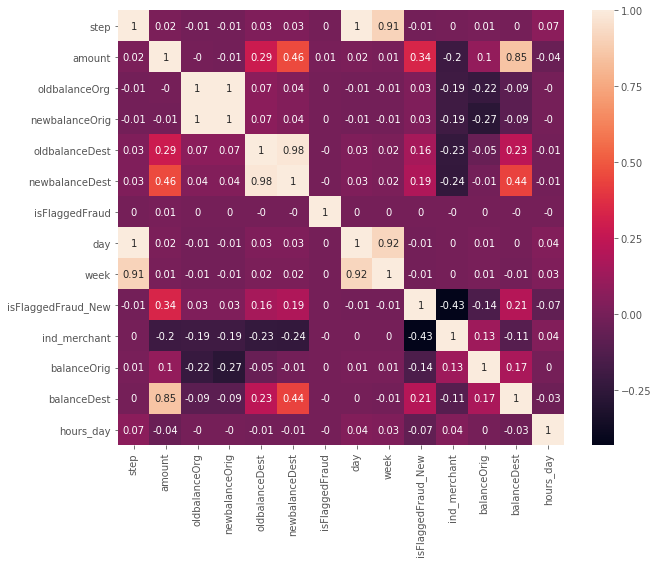

In [12]:
correlation_matrix = mydata_X.corr().round(2)
plt.subplots(figsize=(10,8))
cor = sns.heatmap(data=correlation_matrix, annot=True)

A la vista del gráfico, existe una fuerte dependencia entre las variables *newbalanceOrig* y *oldbalanceOrg* y entre *newbalanceDest* y *oldbalanceDest*. Estas relaciones de dependencia lineal entre las variables tienen sentido ya que suponen el aumento/disminución del balance se realiza sobre la misma cuenta móvil. Además, también existe una dependencia de 1 entre la variable *day* y *step* ya que ambas variables contienen la misma información en diferente escala y entre la variable *day* y *week* puesto que las dos recogen información de tiempo. Además, comprobamos que la variable *isFlaggedFraud* tiene poco poder predictivo puesto que es una variable que aporta muy poca información en el dataframe (total(1)'s: 16), por lo que el coeficiente de correlación de pearson no es capaz de encontrar relación entre esa variable y el resto de predictores.

Siguiendo el resultado de esta matriz de correlaciones, seleccionaríamos las variables: *newbalanceOrig*, *newbalanceDest*, *day*, *hours_day*, *isFlaggedFraud_New*, *balanceOrig*, *balanceDest* y también, la variable *type*.

Sin embargo, para ser más precisos, vamos a reducir el número de variables usando un modelo **random forest classifier**.

## Reducción de atributos

En primer lugar, eliminamos las variables de tipo indicador y aquellas que tienen una correlacción muy alta. Además, convertimos a dummies la variable *type*:

In [8]:
df6 = df.drop(['step', 'nameOrig', 'nameDest', 'amount_category', 'oldbalanceOrg', 'oldbalanceDest', 'week'], axis=1)
df6.shape

(6362620, 12)

In [9]:
df_Dummies = pd.get_dummies(df6)
df_Dummies.head()

,amount,newbalanceOrig,newbalanceDest,isFraud,isFlaggedFraud,day,isFlaggedFraud_New,ind_merchant,balanceOrig,balanceDest,hours_day,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,160296.36,0.0,0.0,0.0,1,0,1,9839.64,0.0,1,0,0,0,1,0
1,1864.28,19384.72,0.0,0.0,0.0,1,0,1,1864.28,0.0,1,0,0,0,1,0
2,181.00,0.00,0.0,1.0,0.0,1,0,0,181.00,0.0,1,0,0,0,0,1
3,181.00,0.00,0.0,1.0,0.0,1,0,0,181.00,-21182.0,1,0,1,0,0,0
4,11668.14,29885.86,0.0,0.0,0.0,1,0,1,11668.14,0.0,1,0,0,0,1,0


Para iniciar con el modelo, separamos en X las variables independientes y en Y la variable dependiente.

In [10]:
y = df_Dummies.loc[:, 'isFraud'].values
X = df_Dummies.drop(columns=['isFraud']).values

Creamos los conjuntos de entrenamiento y test y aplicamos el modelo de Random Forest:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# Entrenar el modelo de Random Forest:
forest = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

In [14]:
# Ordenar los atributos por importancia:
importances = forest.feature_importances_
imp_series = pd.Series(importances, index = df_Dummies.drop(columns=['isFraud']).dtypes.index).sort_values()[::-1]

In [15]:
# Imprimir la lista de los 20 atributos más informativos sobre la clase:
print(imp_series[:20])

balanceOrig           0.378488
balanceDest           0.167273
newbalanceDest        0.151210
amount                0.089406
day                   0.074372
hours_day             0.051844
type_TRANSFER         0.037794
type_CASH_OUT         0.021166
newbalanceOrig        0.020541
isFlaggedFraud_New    0.004017
type_PAYMENT          0.001471
isFlaggedFraud        0.000817
type_CASH_IN          0.000591
ind_merchant          0.000564
type_DEBIT            0.000447
dtype: float64


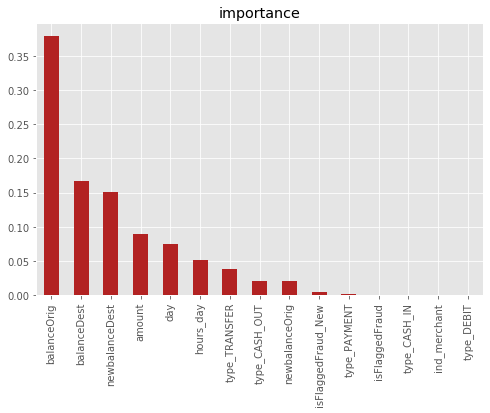

In [16]:
# Gráfica con los 20 atributos más importantes:
h = imp_series[:20].plot(kind = 'bar', figsize = (8, 5), title = "importance", color='firebrick')

Seleccionamos las variables *balanceOrig*, *balanceDest*, *newbalanceDest*, *amount*, *day*, *hours_day*, *type* y *newbalanceOrig* como atributos para nuestro futuro modelo de clasificación.

## Importar DataSets
Importamos los dataset de Train-Test y Evaluación sobre los que se ha aplicado el submuestreo en `05a_Oversampling_PCA`:

### Train_test

In [2]:
s3 = boto3.client("s3")

# Seleccionamos el bucket con el que vamos a trabajar
BUCKET_NAME = 'tfmfraud'

In [3]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'train_test_over.csv',Filename = '/tmp/train_test_over.csv')

In [4]:
#Leemos el fichero y lo metemos en un dataframe.
trainTest = pd.read_csv('/tmp/train_test_over.csv', dtype={'rank':'category'})

In [5]:
trainTest.shape

(470000, 16)

In [6]:
trainTest.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,day,week,isFlaggedFraud_New,ind_merchant,balanceOrig,balanceDest,hours_day,type_TRANSFER,isFraud
0,1,181.0,181.0,0.0,0.0,0.0,0.0,1,1,0,0,181.0,0.0,1,1,1.0
1,1,181.0,181.0,0.0,21182.0,0.0,0.0,1,1,0,0,181.0,-21182.0,1,0,1.0
2,1,2806.0,2806.0,0.0,0.0,0.0,0.0,1,1,0,0,2806.0,0.0,1,1,1.0
3,1,2806.0,2806.0,0.0,26202.0,0.0,0.0,1,1,0,0,2806.0,-26202.0,1,0,1.0
4,1,20128.0,20128.0,0.0,0.0,0.0,0.0,1,1,0,0,20128.0,0.0,1,1,1.0


In [20]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/train_test_over.csv

In [11]:
pd.value_counts(trainTest['isFraud'])

0.0    420800
1.0     49200
Name: isFraud, dtype: int64

In [14]:
trainTest_dis = trainTest[['balanceOrig', 'balanceDest', 'newbalanceDest', 'amount', 'day', 'hours_day', 'type_TRANSFER', 'newbalanceOrig', 'isFraud']]
trainTest_dis.shape

(470000, 9)

### Evaluacion

In [15]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'evaluacion_over.csv',Filename = '/tmp/evaluacion_over.csv')

In [16]:
#Leemos el fichero y lo metemos en un dataframe.
evaluacion = pd.read_csv('/tmp/evaluacion_over.csv', dtype={'rank':'category'})

In [17]:
evaluacion.shape

(80000, 16)

In [18]:
evaluacion.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,day,week,isFlaggedFraud_New,ind_merchant,balanceOrig,balanceDest,hours_day,type_TRANSFER,isFraud
0,225,8.318578e+06,8.318578e+06,0.0,2.558584e+05,8.574436e+06,0.0,9,1,1,0,8.318578e+06,8.318578e+06,20,0,1.0
1,700,3.207200e+05,3.207200e+05,0.0,1.047807e+06,1.368527e+06,0.0,29,3,1,0,3.207200e+05,3.207200e+05,5,0,1.0
2,146,2.480947e+06,2.480947e+06,0.0,0.000000e+00,0.000000e+00,0.0,6,1,1,0,2.480947e+06,0.000000e+00,13,1,1.0
3,191,3.607461e+04,3.607461e+04,0.0,0.000000e+00,0.000000e+00,0.0,8,1,0,0,3.607461e+04,0.000000e+00,19,1,1.0
4,424,2.727997e+04,2.727997e+04,0.0,0.000000e+00,0.000000e+00,0.0,18,3,0,0,2.727997e+04,0.000000e+00,7,1,1.0


In [21]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/evaluacion_over.csv

In [22]:
evaluacion_dis = evaluacion[['balanceOrig', 'balanceDest', 'newbalanceDest', 'amount', 'day', 'hours_day', 'type_TRANSFER', 'newbalanceOrig', 'isFraud']]
evaluacion_dis.shape

(80000, 9)

## Guardamos los dos dataset con las variables seleccionadas

Sobre estos dataframes, ya se ha aplicado la técnica de submuestreo para ajustar la distribución de la clase minoritaria, y equilibrar el conjunto de datos. En este caso, hemos eliminado las tipologías de operación que no contemplan casos fraudulentos.

Guardamos los dataset de Train-Test y Evaluación con las variables seleccionadas:

In [23]:
trainTest_dis.to_csv('/tmp/train_test_ovder_dis.csv', index = False)
evaluacion_dis.to_csv('/tmp/eval_over_dis.csv', index = False)

In [24]:
s3.upload_file(Bucket = BUCKET_NAME, Key = 'train_test_ovder_dis.csv', Filename = '/tmp/train_test_ovder_dis.csv')
s3.upload_file(Bucket = BUCKET_NAME, Key = 'eval_over_dis.csv', Filename = '/tmp/eval_over_dis.csv')

In [25]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/train_test_ovder_dis.csv
!rm /tmp/eval_under_dis.csv

rm: cannot remove ‘/tmp/eval_under_dis.csv’: No such file or directory
